In [1]:
import sys
sys.path[0]="/Users/kwaneu/research/velocity/"
#print(sys.path)
import pandas as pd
import numpy as np
import velocity
from velocity.chemistry import Species, Reaction, Network
from math import sqrt
import lmfit
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [67]:
# settings
observations_filename = "observations new.xlsx"  # spreadsheet filename

# parameter bounds
min_log10_base_rate_constant = -4
max_log10_base_rate_constant = -1
min_log10_selectivity = -1
max_log10_selectivity = 1
min_log10_catalyst_deactivation_rate_constant = -6
default_log10_catalyst_deactivation_rate_constant = np.log10(0.000014)
max_log10_catalyst_deactivation_rate_constant = -4

In [68]:
# setup sugars
glucose = Species("Glc", "glucose")
mannose = Species("Man", "mannose")
altrose = Species("Alt", "altrose")
allose = Species("All", "allose")
gulose = Species("Gul", "gulose")
galactose = Species("Gal", "galactose")
talose = Species("Tal", "talose")
idose = Species("Ido", "idose")

# must match order in spreadsheet!
sugars = [ glucose, mannose, allose, galactose, altrose, talose, gulose, idose ]
sugars_dict = { s.abbreviation : s for s in sugars }
sugar_abbreviations = [ s.abbreviation for s in sugars ]

# setup catalyst
catalyst_active = Species("cat", "catalyst (active)")
catalyst_dead = Species("dead", "catalyst (dead)")

# these are the network connections
CONNECTIONS = ["Glc_All",  "Glc_Gal",  "Glc_Man",
               "All_Gul",  "Gul_Gal",  "Gal_Tal",
               "Tal_Man",  "Man_Alt",  "Alt_All",
               "Alt_Ido",  "Tal_Ido",  "Ido_Gul"]

In [69]:
def add_connection(reactions_dict, connection_string, base_rate_constant, selectivity):
    sugar1, sugar2 = connection_string.split("_")
    sugar1 = sugars_dict[sugar1]
    sugar2 = sugars_dict[sugar2]

    jk1 = base_rate_constant*sqrt(selectivity)
    jk2 = base_rate_constant/sqrt(selectivity)
    reaction = Reaction({sugar1:1, catalyst_active:1}, {sugar2:1, catalyst_active:1}, reversible=True)
    reactions_dict[reaction] = (jk1,jk2)

In [70]:
def create_network(x):
    reactions_dict = {}

    for connection in CONNECTIONS:
        base_rate_constant = np.power(10, x[f"{connection}_log10_base_rate_constant"])
        selectivity = np.power(10, x[f"{connection}_log10_selectivity"])
        add_connection(reactions_dict, connection, base_rate_constant, selectivity)

    catalyst_deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
    reactions_dict[catalyst_deactivation_reaction] = np.power(10.0,x["log10_catalyst_deactivation_rate_constant"])
    
    network = Network(reactions_dict, fixed_concentrations=None)
    return network

In [71]:
def add_parameters(connection, base_rate_constant, selectivity, vary=(False,False)):
    vary_rate, vary_selectivity = vary
    parameter = lmfit.Parameter(
        name = f"{connection}_log10_base_rate_constant",
        min = min_log10_base_rate_constant,
        value = np.log10(base_rate_constant*1e-6),
        max = max_log10_base_rate_constant,
        vary = True
    )
    parameters.add(parameter)

    parameter = lmfit.Parameter(
        name = f"{connection}_log10_selectivity",
        min = min_log10_selectivity,
        value = np.log10(convert(selectivity)),
        max = max_log10_selectivity,
        vary = True
    )
    parameters.add(parameter)

In [72]:
# root mean square average
def rms(x):
    assert isinstance(x, (list,np.ndarray))
    assert len(x) > 0
    return np.sqrt(np.mean(np.square((x))))

In [73]:
def convert(selectivity):
    """Converts negative selectivites into inverse selectivities.

    Leaves positive selectivities untouched.

    Args:
        selectivity (int or float): The selectivity to convert.

    Returns:
        selectivity (float): The converted selectivity.
    """
    selectivity = float(selectivity)
    if selectivity < 0.0:
        selectivity = -1.0/selectivity
    return selectivity

In [74]:
# represents a single experimental isomerization run
class ExperimentalRun():
    def __init__(self, initial_concentrations_dict, description):
        self.initial_concentrations_dict = initial_concentrations_dict
        self.description = description
        self.observation_times = []          # list of floats
        self.observations = []               # list of np.array (float),
                                             # where the outer index parallels observation_times
                                             # and the inner index parallels sugars

    def add_observation(self, observation_time, observed_mole_fractions):
        assert isinstance(observation_time, (int,float)) and observation_time > 0.0
        self.observation_times.append(float(observation_time))
        if isinstance(observed_mole_fractions, np.ndarray):
            observed_mole_fractions = list(observed_mole_fractions)
        assert isinstance(observed_mole_fractions, list)
        assert len(observed_mole_fractions) == len(sugars)
        for i in observed_mole_fractions:
            assert isinstance(i, (int,float)) and i >= 0.0
        observed_mole_fractions = np.array(observed_mole_fractions, dtype=float)
        observed_mole_fractions = observed_mole_fractions / np.sum(observed_mole_fractions)
        self.observations.append(observed_mole_fractions)

In [75]:
observations_df = pd.read_excel(observations_filename)
expected_columns = ["Run", "Time", "Glc", "Man", "All", "Gal", "Alt", "Tal", "Gul", "Ido"]
for s in expected_columns[2:]:
    assert s in sugars_dict
assert len(observations_df.columns) == len(expected_columns)
for c1,c2 in zip(observations_df.columns, expected_columns):
    assert c1 == c2
current_run = None
current_run_number = 0
experimental_runs = []
for _,row in observations_df.iterrows():
    run_number, time, *observations = row
    for o in observations:
        assert 0.0 <= o <= 100.0
    observations = np.array(observations)
    observations = observations / np.sum(observations)
    
    if run_number != current_run_number:
        if current_run:
            experimental_runs.append(current_run)
        assert run_number == current_run_number + 1
        assert time == 0.0, f"expected t=0 but got t={time}"
        initial_concentrations_dict = {
            catalyst_active : 0.2*0.02,
        }
        description = "start = "
        for sugar,mole_fraction in zip(expected_columns[2:], observations):
            if mole_fraction > 0.0:
                sugar = sugars_dict[sugar]
                initial_concentrations_dict[sugar] = 0.2 * mole_fraction
                description += f"{mole_fraction*100:.0f}% {sugar.description} "
        current_run = ExperimentalRun(initial_concentrations_dict, description.strip())
        current_run_number = run_number
    elif run_number == current_run_number:
        current_run.add_observation(time, observations)
    else:
        raise ValueError("impossible")

if current_run:
    experimental_runs.append(current_run)

In [76]:
# generate times to run simulation over
all_times = set()
for r in experimental_runs:
    all_times.update(r.observation_times)
all_times = list(sorted(all_times))
t_span = (0.0, all_times[-1])
t_eval = np.array(all_times)
print(f"Read {len(experimental_runs)} experimental runs.")
print(f"Will evaluate these times within {t_span} s:")
print(all_times)
print()

Read 14 experimental runs.
Will evaluate these times within (0.0, 16920.0) s:
[1200.0, 2400.0, 4800.0, 4920.0, 9600.0, 9720.0, 16800.0, 16920.0]



In [77]:
# run simulations
def run_simulations():
    network = create_network(parameters)
    for run in experimental_runs:
        concentrations_df = network.simulate_timecourse(run.initial_concentrations_dict, t_span, t_eval)
        run.simulation_df = concentrations_df

In [78]:
def plot():
    titles = [ e.description for e in experimental_runs ]
    fig = make_subplots(rows=4, cols=4, subplot_titles=titles, vertical_spacing=0.1, horizontal_spacing=0.03)
    for i,experimental_run in enumerate(experimental_runs):
        # interleave observed and simulated data
        simulation_df = experimental_run.simulation_df[sugar_abbreviations]
        observation_times = experimental_run.observation_times
        data_rows, labels = [], []
        for j,experimental_observations in enumerate(experimental_run.observations):
            data_rows.append(experimental_observations)
            labels.append(f"exp:{t_eval[j]:.0f} s")
            simulated_row = simulation_df.loc[observation_times[j]].to_numpy()
            data_rows.append(simulated_row / np.sum(simulated_row))
            labels.append(f"sim:{t_eval[j]:.0f} s")
        results_df = pd.DataFrame(data_rows, index=labels, columns=sugar_abbreviations)

        # create the bar objects
        row = i // 4 + 1
        col = i % 4 + 1
        count = -1
        colors = ["red","blue"] * len(experimental_run.observations)
        for label,df_row in results_df.iterrows():
            count += 1 
            bar = go.Bar(name=label, x=sugar_abbreviations, y=df_row, marker_color=colors[count])
            fig.add_trace(bar, row=row, col=col)
        fig.update_yaxes(range=[0,1], row=row, col=col)

    fig.update_layout(barmode="group", showlegend=False, height=800, width=1400)
    fig.show()
    

In [79]:
# calculate the loss for a single simulation
# treats all runs with same weight regardless of number of observations
def loss_function(experimental_run, concentrations_df):
    losses = []
    for t,observed in zip(experimental_run.observation_times, experimental_run.observations):
        df = concentrations_df.query(f"index == {t}")
        assert len(df) == 1
        simulated = df[sugar_abbreviations]
        simulated = simulated.iloc[0].to_numpy()
        simulated = simulated / np.sum(simulated)
        loss = rms(simulated-observed)
        losses.append(loss)
    return rms(losses)

In [80]:
'''
add_parameters("Glc_All",  11776,  10, (True,True))
add_parameters("Glc_Gal",   3826,   1,  (True,True))
add_parameters("Glc_Man",   1316, -10,  (True,True))
add_parameters("All_Gul",   2889, -10, )
add_parameters("Gul_Gal",   7182,   1,)
add_parameters("Gal_Tal",   2719,  10,)
add_parameters("Tal_Man",   4889, -10, )
add_parameters("Man_Alt",   8314,  -2,  )
add_parameters("Alt_All",   2056,  10, )
add_parameters("Alt_Ido",   5401,   1, )
add_parameters("Tal_Ido",   4487, -10, )
add_parameters("Ido_Gul",   2518,   2, )

add_parameters("Glc_All",  11736,  10)
add_parameters("Glc_Gal",   2414,   1)
add_parameters("Glc_Man",    936, -10)
add_parameters("All_Gul",   3703, -10)
add_parameters("Gul_Gal",   4163,   1)
add_parameters("Gal_Tal",   2814,  10)
add_parameters("Tal_Man",   5043, -10)
add_parameters("Man_Alt",   7914,  -2)
add_parameters("Alt_All",   3217,  10)
add_parameters("Alt_Ido",   2520,   1)
add_parameters("Tal_Ido",   5022, -10)
add_parameters("Ido_Gul",   1807,   2)

add_parameters("Glc_All",  5000,  1)
add_parameters("Glc_Gal",  5000,   1)
add_parameters("Glc_Man",  5000, 1)
add_parameters("All_Gul",  5000, 1)
add_parameters("Gul_Gal",  5000,   1)
add_parameters("Gal_Tal",  5000,  1)
add_parameters("Tal_Man",   5000, 1)
add_parameters("Man_Alt",   5000,  1)
add_parameters("Alt_All",   5000,  1)
add_parameters("Alt_Ido",   5000,   1)
add_parameters("Tal_Ido",   5000, 1)
add_parameters("Ido_Gul",   5000,   1)

add_parameters("Glc_All",  12212,  10)
add_parameters("Glc_Gal",  7509,   1)
add_parameters("Glc_Man",   100, 5)
add_parameters("All_Gul",  5006, -2)
add_parameters("Gul_Gal",   215,   -7)
add_parameters("Gal_Tal",   275,  -4)
add_parameters("Tal_Man",  8814, -5)
add_parameters("Man_Alt",   101,  2)
add_parameters("Alt_All",  6095,  6)
add_parameters("Alt_Ido",   794,   -3)
add_parameters("Tal_Ido",  5988, -9)
add_parameters("Ido_Gul",  5023,   -2)

add_parameters("Glc_All", 20000, 10)
add_parameters("Glc_Gal",  5000,  1)
add_parameters("Glc_Man",  5000,  1)
add_parameters("All_Gul",  5000, -5)
add_parameters("Gul_Gal",  3000, -5)
add_parameters("Gal_Tal",  5000,  5)
add_parameters("Tal_Man",  5000, -5)
add_parameters("Man_Alt",  5000, -5)
add_parameters("Alt_All",  5000,  5)
add_parameters("Alt_Ido",  5000,  1)
add_parameters("Tal_Ido",  5000, -10)
add_parameters("Ido_Gul",  5000,  1)

add_parameters("Glc_All", 11579, 10)
add_parameters("Glc_Gal",  2734,  2)
add_parameters("Glc_Man",  2239, -2)
add_parameters("All_Gul",  3600, -9)
add_parameters("Gul_Gal",  3000, -5)
add_parameters("Gal_Tal",  3117,  7)
add_parameters("Tal_Man",  5488, -8)
add_parameters("Man_Alt",  6163, -3)
add_parameters("Alt_All",  3100,  8)
add_parameters("Alt_Ido",  4473,  1)
add_parameters("Tal_Ido",  5018, -10)
add_parameters("Ido_Gul",  2187,  1)

add_parameters("Glc_All", 11690,  10)
add_parameters("Glc_Gal",  2772,   1)
add_parameters("Glc_Man",  1791,  -3)
add_parameters("All_Gul",  3405, -10)
add_parameters("Gul_Gal",  5266,   1)
add_parameters("Gal_Tal",  2724,  10)
add_parameters("Tal_Man",  4949, -10)
add_parameters("Man_Alt",  7816,  -2)
add_parameters("Alt_All",  2852,  10)
add_parameters("Alt_Ido",  4305,   1)
add_parameters("Tal_Ido",  4891, -10)
add_parameters("Ido_Gul",  2080,   2)
'''

'\nadd_parameters("Glc_All",  11776,  10, (True,True))\nadd_parameters("Glc_Gal",   3826,   1,  (True,True))\nadd_parameters("Glc_Man",   1316, -10,  (True,True))\nadd_parameters("All_Gul",   2889, -10, )\nadd_parameters("Gul_Gal",   7182,   1,)\nadd_parameters("Gal_Tal",   2719,  10,)\nadd_parameters("Tal_Man",   4889, -10, )\nadd_parameters("Man_Alt",   8314,  -2,  )\nadd_parameters("Alt_All",   2056,  10, )\nadd_parameters("Alt_Ido",   5401,   1, )\nadd_parameters("Tal_Ido",   4487, -10, )\nadd_parameters("Ido_Gul",   2518,   2, )\n\nadd_parameters("Glc_All",  11736,  10)\nadd_parameters("Glc_Gal",   2414,   1)\nadd_parameters("Glc_Man",    936, -10)\nadd_parameters("All_Gul",   3703, -10)\nadd_parameters("Gul_Gal",   4163,   1)\nadd_parameters("Gal_Tal",   2814,  10)\nadd_parameters("Tal_Man",   5043, -10)\nadd_parameters("Man_Alt",   7914,  -2)\nadd_parameters("Alt_All",   3217,  10)\nadd_parameters("Alt_Ido",   2520,   1)\nadd_parameters("Tal_Ido",   5022, -10)\nadd_parameters("I

In [95]:
parameters = lmfit.Parameters()

add_parameters("Glc_All", 11413,  10)
add_parameters("Glc_Gal",  2788,   1)
add_parameters("Glc_Man",  1745,  -3)
add_parameters("All_Gul",  3408, -10)
add_parameters("Gul_Gal",  5165,   1)
add_parameters("Gal_Tal",  2556,  10)
add_parameters("Tal_Man",  4366, -10)
add_parameters("Man_Alt",  7893,  -2)
add_parameters("Alt_All",  2632,  10)
add_parameters("Alt_Ido",  4593,   1)
add_parameters("Tal_Ido",  4783, -10)
add_parameters("Ido_Gul",  2087,   2)

parameter = lmfit.Parameter(
    name = f"log10_catalyst_deactivation_rate_constant",
    min = min_log10_catalyst_deactivation_rate_constant,
    value = default_log10_catalyst_deactivation_rate_constant,
    max = max_log10_catalyst_deactivation_rate_constant,
    vary = False
)
parameters.add(parameter)
#parameters.pretty_print()
#print(f"There are {len(parameters)} parameters.\n")

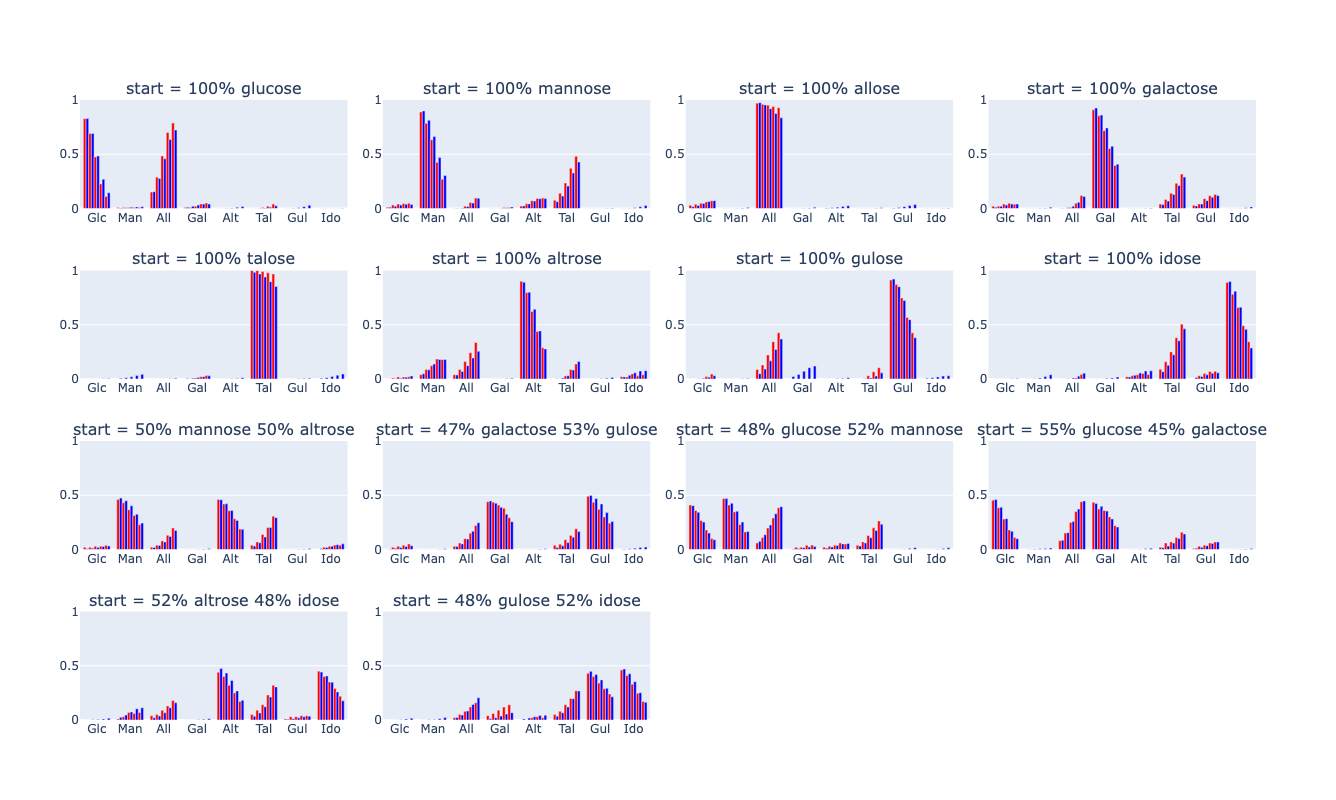

In [96]:
run_simulations()
plot() # red is experiment, blue is simulated

In [83]:
network = create_network(parameters)

# run simulations
losses = []
report_string = ""
for i,run in enumerate(experimental_runs):
    concentrations_df = network.simulate_timecourse(run.initial_concentrations_dict, t_span, t_eval)
    loss = loss_function(run, concentrations_df)
    loss = max(0.0, loss-0.020)+0.020
    report_string += f"{loss:.4f}   "
    losses.append(loss)

# aggregate losses
loss = rms(losses) #+ np.std(losses)
print(f"{report_string}  ::: {loss:8.4f}")

0.0200   0.0200   0.0220   0.0200   0.0299   0.0200   0.0381   0.0200   0.0200   0.0201   0.0200   0.0200   0.0200   0.0240     :::   0.0230


In [84]:
def deuteration_loss_function(parameters):
    def get_value(connection):
        value = parameters[f"{connection}_log10_base_rate_constant"].value
        return np.power(10, value)
    
    def get_fraction(connection_tuple):
        numerator = get_value(connection_tuple[0])
        denominator = get_value(connection_tuple[1])
        return numerator/(numerator+denominator)
                                
    ratios_dict = {
        # mannose
        ("Glc_Man","Tal_Man") : 1/7,
        
        # glucose
        ("Glc_Man","Glc_All") : 1/12,
        ("Glc_All","Glc_Gal") : 12/2,
        ("Glc_Man","Glc_Gal") : 1/2,
        
        # allose
        ("Alt_All","Glc_All") : 2/15,
        ("Glc_All","All_Gul") : 15/4,
        ("Alt_All","All_Gul") : 2/4,
        
        # talose
        ("Gal_Tal","Tal_Ido") : 2/4,
        ("Tal_Ido","Tal_Man") : 4/4,
        ("Gal_Tal","Tal_Man") : 2/4,
        
        # idose
        ("Ido_Gul","Tal_Ido") : 2/2,
        ("Tal_Ido","Alt_Ido") : 2/3,
        ("Ido_Gul","Alt_Ido") : 2/3,
        
        # galactose
        ("Gal_Tal","Gul_Gal") : 7/13,
        ("Gul_Gal","Glc_Gal") : 13/12,
        ("Gal_Tal","Glc_Gal") : 7/12,
        
        # altrose
        ("Alt_All","Man_Alt") : 1/9,
        ("Man_Alt","Alt_Ido") : 9/7,
        ("Alt_All","Alt_Ido") : 1/7,
        
        # gulose
        ("Ido_Gul","Gul_Gal") : 1/8,
        ("Gul_Gal","All_Gul") : 8/1,
        ("Ido_Gul","All_Gul") : 1/1,
    }
    
    rows = []
    for connection_tuple,observed_ratio in ratios_dict.items():
        observed_fraction = observed_ratio / (observed_ratio + 1)
        simulated_fraction = get_fraction(connection_tuple)
        loss = np.square(observed_fraction-simulated_fraction)
        #print(observed_fraction, simulated_fraction, loss)
        row = [ connection_tuple, observed_fraction, simulated_fraction, loss ]
        rows.append(row)
    df = pd.DataFrame(rows, columns=["connection", "observed", "simulated", "loss"])
    loss = rms(df.loss.to_numpy())
    
    return loss, df

0.027850139686730214


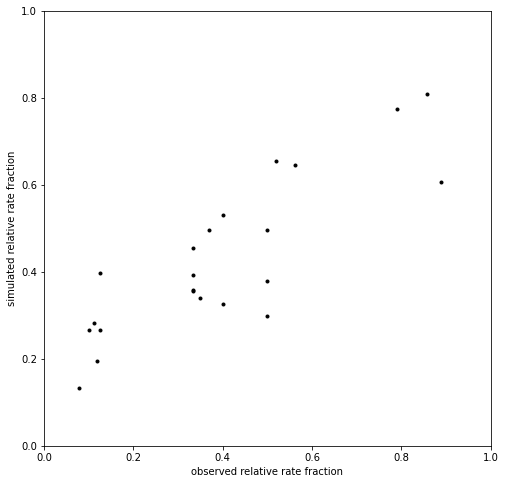

In [85]:
loss, df = deuteration_loss_function(parameters)
print(loss)
plt.figure(figsize=(8,8))
plt.plot(df.observed, df.simulated, "k.")
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("simulated relative rate fraction")
plt.xlabel("observed relative rate fraction")
plt.show()

In [86]:
# simulate each experimental run for one set of parameters
def trial(x):
    global iteration, best_loss
    iteration += 1
    network = create_network(x)

    # run simulations
    losses = []
    #x.pretty_print()
    report_string = ""
    for i,run in enumerate(experimental_runs, start=1):
        concentrations_df = network.simulate_timecourse(run.initial_concentrations_dict, t_span, t_eval)
        loss = loss_function(run, concentrations_df)
        loss = max(0.0, loss-0.020)+0.020
        report_string += f"{loss:8.4f} "
        losses.append(loss)
        
    # compute deuteration loss
    deuteration_loss, df = deuteration_loss_function(x)
    report_string += f"{deuteration_loss:8.4f} "
    losses.append(deuteration_loss)
    
    # aggregate losses
    loss = rms(losses)
    if not best_loss or loss < best_loss:
        best_loss = loss

    #history.append((loss, losses, x))
        
    # report progress
    print(f"{report_string}  ::: {loss:8.4f} (best={best_loss:8.4f})  (iteration={iteration})", end="\r", flush=True)
    if iteration == 1:
        print()
    return loss

In [93]:
# run the optimization
# def iter_cb(parameters, iteration, residual):
#     print(f"iteration {iteration:5d}   loss = {residual:12.4f}", flush=True)
iteration = 0
best_loss = None
results = lmfit.minimize(trial, parameters, method="cg", max_nfev=500)
#results = lmfit.minimize(trial, results.params, method="cg", max_nfev=500)

  0.0200   0.0200   0.0220   0.0200   0.0299   0.0200   0.0381   0.0200   0.0200   0.0201   0.0200   0.0200   0.0200   0.0240   0.0279   :::   0.0234 (best=  0.0234)  (iteration=1)


In [94]:
#print(lmfit.fit_report(results))
print()
print_count = 0
# params is the best params (see lmfit docs)
for name, param in results.params.items():
    print_count += 1
    value = np.power(10.0, param.value)
    if "rate" in name:
        value = value*1e6
    if print_count % 2:
        print(f"{name:42s} {value:10.0f}   ", end="")
    else:
        if value < 1:
            value = -1/value
        print(f"{value:10.0f}")
print()


Glc_All_log10_base_rate_constant                11413           10
Glc_Gal_log10_base_rate_constant                 2788            1
Glc_Man_log10_base_rate_constant                 1745           -3
All_Gul_log10_base_rate_constant                 3408          -10
Gul_Gal_log10_base_rate_constant                 5165           -1
Gal_Tal_log10_base_rate_constant                 2556           10
Tal_Man_log10_base_rate_constant                 4366          -10
Man_Alt_log10_base_rate_constant                 7893           -2
Alt_All_log10_base_rate_constant                 2632           10
Alt_Ido_log10_base_rate_constant                 4593            1
Tal_Ido_log10_base_rate_constant                 4783          -10
Ido_Gul_log10_base_rate_constant                 2087            2
log10_catalyst_deactivation_rate_constant          14   
